# Project: Build a Traffic Sign Recognition Classifier Using Inception and LeNet Architectures

Deep learning networks are increasingly becoming effective at image classification. Quickly they are surpassing traditional computer vision techniques in many areas including image classification of street signs. Autonomous vehicles can use deep learning networks to classify images takes from external cameras of street signs in order to help them follow the rules of the road in our current sign based traffic infrastructure. 

In this project, the German Traffic Sign Recognition Benchmark ('GTSRB') [dataset](http://benchmark.ini.rub.de/) is used to train two different convolutional neural networks based on the popular Inception and LeNet architectures. The performances are compared and discussed. As well, the networks trained are tested on images outisde of the dataset.


## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load Data

training_file = "./data/train.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

A basic data summary is shown below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset 

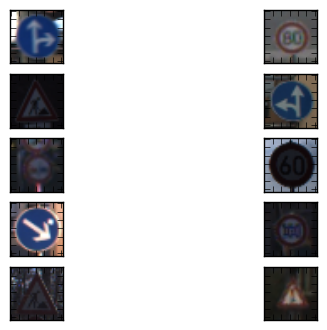

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
indx = np.arange(y_train.shape[0])
# shuffle the indices
np.random.shuffle(indx)
# create subplot and fill with images
f, axarr = plt.subplots(5, 2)
for i in range(5):
    for j in range(2):
        axarr[i, j].imshow(X_train[indx[j+5*i]])
        plt.setp(axarr[i,j].get_xticklabels(), visible=False)
        plt.setp(axarr[i,j].get_yticklabels(), visible=False)
plt.show()



----

# Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

## Preprocessing

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import time
from tqdm import tqdm
from six.moves import cPickle as pickle
import os
import cv2
from sklearn.cross_validation import train_test_split

pixel_depth = 255.0

def preprocess(image):
    image = image.astype(float)
    return (image-pixel_depth/2)/pixel_depth

def preprocess_batch(images):
    imgs = np.copy(images)
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess(images[i])
    return imgs

X_train_processed = preprocess_batch(X_train.astype(float))
X_test_processed = preprocess_batch(X_test.astype(float))


# We will use 80% for training and 20% for validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train_processed, 
                                                                y_train, 
                                                                test_size=0.20, 
                                                                random_state=42)

#Make sure all the sets line up and print shapes.
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))



/home/carnd/anaconda3/envs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
100%|██████████| 12630/12630 [00:00<00:00, 32019.93it/s]



Image Shape: (32, 32, 3)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples


### Question 1 

Before doing training for the model, the feaures (or pixel values) were scaled across all three color channels). Features scaling though normalization can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have a mean of zero and a standard deviation of approximately one. For deep learning, standardization is especially important when it comes to back propagation and gradient decent. To illustrate this concept, I will borrow some slides from Andrew Ng's machine learning lecture. Suppose you are trying to optimize a function with two variables. The resulting optimization using gradient decent will look roughly like this:

![gradient decent](http://1.bp.blogspot.com/-Lg0QSQz7HLo/VjROaiROGDI/AAAAAAAAAIg/PJLs8idA7HI/s1600/Capture3.GIF)
<center> Source: Andrew Ng </center>

On the left is the optimization performed where one feature has a larger variance than the other feature. As can be seen by the red line, which represents the steps made from doing stochastic gradient decent, the solution may often take longer than a feature space with equal variance. The result in the context of a deep neurl netowrk is that training will take a lot less time if the features are normalized before training takes place.



### Question 2

Three different sets of data are using in this project: training, validation and testing. The training set is used to train the model. In order to judge the intermediate performance of the model, the model is used to generate predictions and compared against the validation sets labels. This allows for development of the model, in order to optimize the validation score. When the validation score is as good as can be, and the model is finalized, the model is then tested against the held-out set to determine what the real world score schould be expected to be. 

The reason that this is nessesary is that only having one testing set will cause the model to effectively learn the values by continued iterations of the model's parameters to get a high test score. If this takes place, it can cause a false sense of how well the model will perform given new data.

For our project, the existing data is shuffled, and split into a 80% training, 20% validation set. The existing test set is held-out until the end of the experiement.

# Building the Model

## LeNet Based Architecture with Dropout

The first network architecture used is based on the LeNet architecture. The LeNet architecture is often used as a starting point to develop a model as it is relatively lightweight (can be trained using a laptop) and performs well on datasets that don't have too many classes. The basic architecture of the LeNet can be visualized as follows:

![lenet](http://eblearn.sourceforge.net/lib/exe/lenet5.png)
<center> Source: Yann Lecun </center>

__Modifications__:
As the original LeNet architecture was made for the MNIST dataset, it was modified to output 43 classes instead of 10 classes. In addition, the dropout technique was added in order to reduce overfitting.

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

model_name = 'lenet_report'


def lenet(x, dropout):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2 =tf.nn.dropout(tf.nn.relu(fc2), dropout)


    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


#Training Pipeline
rate = 0.001

logits = lenet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## LeNet Training

In [6]:
EPOCHS = 100
BATCH_SIZE = 128
dropout = 0.75

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout })
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './models/'+model_name)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.761

EPOCH 2 ...
Validation Accuracy = 0.871

EPOCH 3 ...
Validation Accuracy = 0.937

EPOCH 4 ...
Validation Accuracy = 0.956

EPOCH 5 ...
Validation Accuracy = 0.958

EPOCH 6 ...
Validation Accuracy = 0.970

EPOCH 7 ...
Validation Accuracy = 0.974

EPOCH 8 ...
Validation Accuracy = 0.978

EPOCH 9 ...
Validation Accuracy = 0.977

EPOCH 10 ...
Validation Accuracy = 0.980

EPOCH 11 ...
Validation Accuracy = 0.982

EPOCH 12 ...
Validation Accuracy = 0.987

EPOCH 13 ...
Validation Accuracy = 0.984

EPOCH 14 ...
Validation Accuracy = 0.985

EPOCH 15 ...
Validation Accuracy = 0.986

EPOCH 16 ...
Validation Accuracy = 0.986

EPOCH 17 ...
Validation Accuracy = 0.985

EPOCH 18 ...
Validation Accuracy = 0.988

EPOCH 19 ...
Validation Accuracy = 0.986

EPOCH 20 ...
Validation Accuracy = 0.987

EPOCH 21 ...
Validation Accuracy = 0.983

EPOCH 22 ...
Validation Accuracy = 0.985

EPOCH 23 ...
Validation Accuracy = 0.985

EPOCH 24 ...
Validation Accura

## Test the LeNet Model

In [7]:
with tf.Session() as sess:
    print ('loading '+model_name+'...')
    saver.restore(sess,   './models/'+model_name)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

loading lenet_report...
Test Accuracy = 0.941


## LeNet Model Discussion

The best score achieved on the validation set with the LeNet network is 0.992 for 100 training epochs. On testing the network on the held out dataset, it achieves a score of 0.941. This is a great score, considering how easy it is to train the LeNet network (roughly 20 minutes using a g2.2xlarge instance).

## Inception Based Network

GoogLeNet is a network architecture that performs notably well for image classification tasks. A main difference between GoogLeNet and LeNet is the inception module. The inception module can be visualized as follows:

![inception](https://culurciello.github.io/assets/nets/inceptionv1.jpg)

Often, when designing a network, it is unclear wheather to use a 5x5, 3x3 1x1 or maxpooling function. The inception module takes the guess work out of the process. It uses them all and concatinates the results in the end. In this manner, the network teaches itself which of the functions is the best to use.

__Modifications__:

As the original GoogLeNet took roughly 1 week to train on GPU that were far better than this laptop, a smaller network is trained that uses inceptions modules. Specifically this network is: An inceptions module --> A second inception module --> a fully connected layer --> dropout --> the output classification layer.

## AWS EC2 Instance

As my laptop does not possess the neccesary horsepower to train the inception network, a AWS EC2 GPU instance is used. The specific instance used is the `g2.2xlarge` instance with the following propertie:

| Model      | GPUs | vCPU | Mem (GiB) | SSD Storage (GB) |
|------------|------|------|-----------|------------------|
| g2.2xlarge | 1    | 8    | 15        | 1 x 60           |

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# Hyperparameters
batch_size = 50
map1 = 32
map2 = 64
num_fc1 = 700 #1028
num_fc2 = 43
reduce1x1 = 16
dropout = 0.50
model_name = 'inception_dropout'



def createWeight(size,Name):
    return tf.Variable(tf.truncated_normal(size, stddev=0.1),
                      name=Name)

def createBias(size,Name):
    return tf.Variable(tf.constant(0.1,shape=size),
                      name=Name)

def conv2d_s1(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_3x3_s1(x):
    return tf.nn.max_pool(x,ksize=[1,3,3,1],
                         strides=[1,1,1,1],padding='SAME')


#Inception Module 1
#
#follows input
W_conv1_1x1_1 = createWeight([1,1,3,map1],'W_conv1_1x1_1')
b_conv1_1x1_1 = createWeight([map1],'b_conv1_1x1_1')

#follows input
W_conv1_1x1_2 = createWeight([1,1,3,reduce1x1],'W_conv1_1x1_2')
b_conv1_1x1_2 = createWeight([reduce1x1],'b_conv1_1x1_2')

#follows input
W_conv1_1x1_3 = createWeight([1,1,3,reduce1x1],'W_conv1_1x1_3')
b_conv1_1x1_3 = createWeight([reduce1x1],'b_conv1_1x1_3')

#follows 1x1_2
W_conv1_3x3 = createWeight([3,3,reduce1x1,map1],'W_conv1_3x3')
b_conv1_3x3 = createWeight([map1],'b_conv1_3x3')

#follows 1x1_3
W_conv1_5x5 = createWeight([5,5,reduce1x1,map1],'W_conv1_5x5')
b_conv1_5x5 = createBias([map1],'b_conv1_5x5')

#follows max pooling
W_conv1_1x1_4= createWeight([1,1,3,map1],'W_conv1_1x1_4')
b_conv1_1x1_4= createWeight([map1],'b_conv1_1x1_4')



#Inception Module 2
#
#follows inception1
W_conv2_1x1_1 = createWeight([1,1,4*map1,map2],'W_conv2_1x1_1')
b_conv2_1x1_1 = createWeight([map2],'b_conv2_1x1_1')

#follows inception1
W_conv2_1x1_2 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_2')
b_conv2_1x1_2 = createWeight([reduce1x1],'b_conv2_1x1_2')

#follows inception1
W_conv2_1x1_3 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_3')
b_conv2_1x1_3 = createWeight([reduce1x1],'b_conv2_1x1_3')

#follows 1x1_2
W_conv2_3x3 = createWeight([3,3,reduce1x1,map2],'W_conv2_3x3')
b_conv2_3x3 = createWeight([map2],'b_conv2_3x3')

#follows 1x1_3
W_conv2_5x5 = createWeight([5,5,reduce1x1,map2],'W_conv2_5x5')
b_conv2_5x5 = createBias([map2],'b_conv2_5x5')

#follows max pooling
W_conv2_1x1_4= createWeight([1,1,4*map1,map2],'W_conv2_1x1_4')
b_conv2_1x1_4= createWeight([map2],'b_conv2_1x1_4')



#Fully connected layers
#since padding is same, the feature map with there will be 4 32*32*map2
W_fc1 = createWeight([32*32*(4*map2),num_fc1],'W_fc1')
b_fc1 = createBias([num_fc1],'b_fc1')

W_fc2 = createWeight([num_fc1,num_fc2],'W_fc2')
b_fc2 = createBias([num_fc2],'b_fc2')


   
def inception(x, keep_prob): 
    #Inception Module 1
    conv1_1x1_1 = conv2d_s1(x,W_conv1_1x1_1)+b_conv1_1x1_1
    conv1_1x1_2 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_2)+b_conv1_1x1_2)
    conv1_1x1_3 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_3)+b_conv1_1x1_3)
    conv1_3x3 = conv2d_s1(conv1_1x1_2,W_conv1_3x3)+b_conv1_3x3
    conv1_5x5 = conv2d_s1(conv1_1x1_3,W_conv1_5x5)+b_conv1_5x5
    maxpool1 = max_pool_3x3_s1(x)
    conv1_1x1_4 = conv2d_s1(maxpool1,W_conv1_1x1_4)+b_conv1_1x1_4

    #concatenate all the feature maps and hit them with a relu
    inception1 = tf.nn.relu(tf.concat(3,[conv1_1x1_1,conv1_3x3,conv1_5x5,conv1_1x1_4]))


    #Inception Module 2
    conv2_1x1_1 = conv2d_s1(inception1,W_conv2_1x1_1)+b_conv2_1x1_1
    conv2_1x1_2 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_2)+b_conv2_1x1_2)
    conv2_1x1_3 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_3)+b_conv2_1x1_3)
    conv2_3x3 = conv2d_s1(conv2_1x1_2,W_conv2_3x3)+b_conv2_3x3
    conv2_5x5 = conv2d_s1(conv2_1x1_3,W_conv2_5x5)+b_conv2_5x5
    maxpool2 = max_pool_3x3_s1(inception1)
    conv2_1x1_4 = conv2d_s1(maxpool2,W_conv2_1x1_4)+b_conv2_1x1_4

    #concatenate all the feature maps and hit them with a relu
    inception2 = tf.nn.relu(tf.concat(3,[conv2_1x1_1,conv2_3x3,conv2_5x5,conv2_1x1_4]))

    #flatten features for fully connected layer
    inception2_flat = tf.reshape(inception2,[-1,32*32*4*map2])

    #Fully connected layers, w/ dropout

    h_fc1 =tf.nn.dropout(tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1),keep_prob)

        
    #Layer2
    logits = tf.matmul(h_fc1,W_fc2)+b_fc2

    return logits

#Variables
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


#Training Pipelin
rate = 0.001
logits = inception(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#The correct_prediction line works with softmax output.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


#Evaluation pipeline
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Inception Model

In [9]:
EPOCHS = 10
BATCH_SIZE = 128



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout })
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'models/'+model_name)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.633

EPOCH 2 ...
Validation Accuracy = 0.925

EPOCH 3 ...
Validation Accuracy = 0.958

EPOCH 4 ...
Validation Accuracy = 0.974

EPOCH 5 ...
Validation Accuracy = 0.980

EPOCH 6 ...
Validation Accuracy = 0.983

EPOCH 7 ...
Validation Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.985

EPOCH 9 ...
Validation Accuracy = 0.987

EPOCH 10 ...
Validation Accuracy = 0.984

Model saved


## Test the Inception Model
This is the final test performed on held out test set.

In [14]:
with tf.Session() as sess:
    saver.restore(sess, 'models/'+model_name)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.607


## Inception Discussion

As the inception module took roughly 5 hours to train on the EC2 instance, it is rather disappointing to see that it overfit the data so much and that the test accuracy was 0.607. Perhpas this is to be expected, as the original GoogLeNet was 22 layers deep, and our light version was only 6 layers deep. As it was rather computationally expensive to train the Inception network, and the LeNet performed fairly well, the LeNet will be the network used for the rest of this project.

In order to improve these results in the future, a small training rate should be used. It can be seen from the log that the network quickly jumps to a 0.925 sucess rate ont he validation set. This is an indication that the network is overfitting and should have aslower learning rate. In addition, the LeNet trained for this project used 100 epochs to train itself. The Inception based network only used 10. 


### Question 3


The final network architecture is as follows:

| Type                	| Input Size 	| Patch Size / Stride 	| Output Size 	| Padding 	|
|---------------------	|------------	|---------------------	|-------------	|---------	|
| convolution         	|   32x32x3  	|       5x5 / 1       	|   28x28x6   	|  VALID  	|
| relu_activation     	|      -     	|          -          	|      -      	|    -    	|
| max_pool            	|   28x28x6  	|       2x2 / 2       	|   14x14x6   	|  VALID  	|
| convolution         	|   14x14x6  	|       5x5 / 1       	|   10x10x16  	|  VALID  	|
| relu_activation     	|      -     	|          -          	|      -      	|    -    	|
| max_pool            	|  10x10x16  	|       2x2 / 1       	|    5x5x16   	|  VALID  	|
| flatten             	|   5x5x16   	|          -          	|    400x1    	|    -    	|
| fully_connected     	|    400x1   	|          -          	|    120x1    	|    -    	|
| fully_connected     	|    120x1   	|          -          	|     84x1    	|    -    	|
| dropout             	|      -     	|          -          	|      -      	|    -    	|
| fully_connected_out 	|    84x1    	|          -          	|     43x1    	|    -    	|

### Question 4


In order to train the model the following parameters of the network were used:

* _Optimizer_: Adam optimizer. This optimizer has been [empirically shown](https://arxiv.org/abs/1412.6980) to work well with stochastic gradient decent.
* _Batch Size_: 128
* _Epochs_: 100
* _Hyperparameters_: mu = 0, sigma = 1 (refering to initialization of weights in the network)

The Final network was trained on a AWS EC2 GPU instance (g2.2xlarge)

## Question 5

__Research__

The first step taken to solving this problem was to do a literature search. The following two papers talk about the sucess of the GooLeNet and the Inception module, and were good motivation to try using inception for this problem:

* [Going Deeper with Convolutions](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf)
* [Traffic Sign Classification Using Deep Inception
Based Convolutional Networks](https://arxiv.org/pdf/1511.02992.pdf)

__Preprocessing__

Several different preprocessing steps were attempted for the images. 

_Greyscaling_: The first was to look at greyscaling the images. This would reduce the features space by 2/3 as the number of color channels goes from 3 to 1. This would result in faster training. Greyscaling the images resulted in a poorer validation result as the images lost too much of the information contained in the colors of the images

_RGB to HSV and YUV_: As some of the pictures were taken under different lighting conditions, it was theorized changing color space would help acount for some of the variance. This was again rejected as it reduced the validation score.

_Image Denoising_: A high degree of noise to be present in some images due to lighting and camera conditions. Denoising the images smooths out the pixel values thereby reducing bias from being introduced in the neural network. This was again rejected as it reduced the validation score.

__Architecture__

Finally, the dropout ration and and number of epochs of the network themselves were adjusted with the following results:

| Architecture      | Dropout | Epoches | Validation Results | Test Results |
|-------------------|---------|---------|--------------------|--------------|
| LeNet             |   0.0   |    10   |        0.951       |       -      |
| LeNet             |   0.5   |    10   |        0.965       |       -      |
| LeNet             |   0.5   |   100   |        0.992       |    .941      |
| LeNet             |   0.75  |    50   |        0.985       |       -      |
| LeNet (Final)     |   0.5   |    50   |        0.991       |     0.917    |
| Inception (Final) |   0.5   |    10   |        0.987       |     0.60     |

---

## Step 3: Test a Model on New Images

Several pictures of traffic signs from the internet were downloaded from the internet in order to test the model further. The images are manually cropped to be 32x32.


In [8]:
# load test images
from skimage import io
import numpy as np

num_imgs = 9
test_imgs = np.uint8(np.zeros((num_imgs,32,32,3)))

for i in range(1,num_imgs+1):
    image = io.imread('./images/test-image{}.jpg'.format(str(i)))
    test_imgs[i-1] = image

test_img_data = test_imgs.reshape((-1, 32, 32, 3)).astype(np.float32)


### Question 6

The images are visualized as follows:

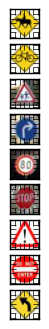

(9, 32, 32, 3)

In [9]:
f, ax = plt.subplots(num_imgs, 1)
for i in range(num_imgs):
    ax[i].imshow(test_imgs[i])
    plt.setp(ax[i].get_xticklabels(), visible=False)
    plt.setp(ax[i].get_yticklabels(), visible=False)

plt.show()
test_imgs.shape

Conditions for identification are not ideal in the second and last image. In the second image of a bike yield sign, the bike is quite blurry. In the last image of a stop sign, the lighting is significantly different than the other images.

A summary of the test signs and their categories is shown in the following table:

| Test Image | Sign Category            |
|------------|--------------------------|
| 1          | Wild Animals Crossing - 31|
| 2          | Bicycles crossing - 29   |
| 3          | Children Crossing - 28   |
| 4          | Turn Right ahead - 33    |
| 5          | Speed limit (80km/h) - 5 |
| 6          | Stop - 14                |
| 7          | General Caution - 18     |
| 8          | No Entry - 17            |
| 9          | Turn Left ahead - 34     |

In [10]:
predictions = tf.nn.softmax(logits)

def classify_images(X_data):
    sess = tf.get_default_session()
    pred_vals = sess.run(predictions, feed_dict={x: X_data, keep_prob: 1.0})
    return pred_vals
    
with tf.Session() as sess:
    print ('loading '+model_name+'...')
    saver.restore(sess, './models/'+model_name)
    predictions = classify_images(test_img_data)
    top_k = sess.run(tf.nn.top_k(predictions, 5, sorted=True))
    print("Predicted Labels:", np.argmax(predictions, 1))

loading lenet_report...
Predicted Labels: [ 4  1 28 33  5 14 18 17  4]


### Question 7

Of the 9 images tested using this network, 6 were classified correctly. This is to be expected as some of the signs were not in the original dataset. As a percentage this is 66.6% correct, which is much less than our testing score of 94.1% in the german sign dataset.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

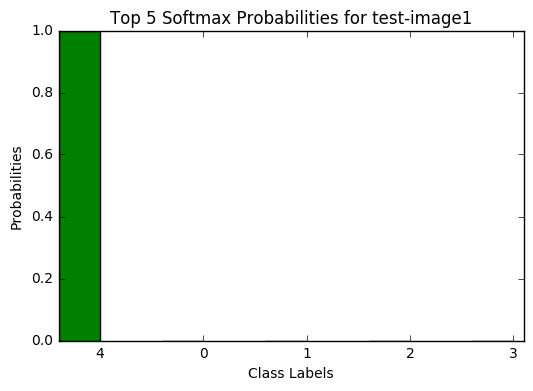

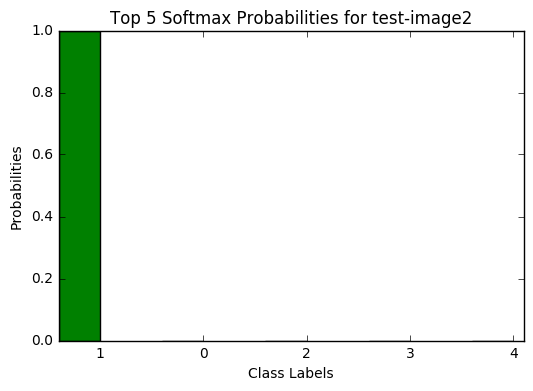

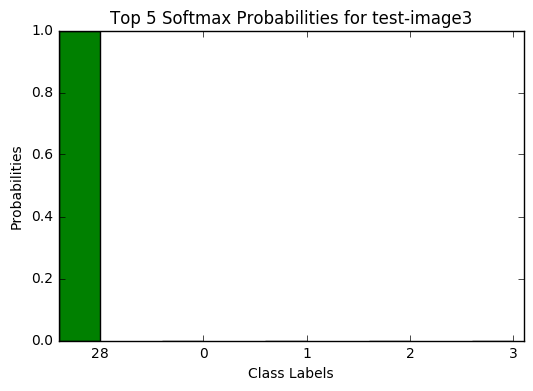

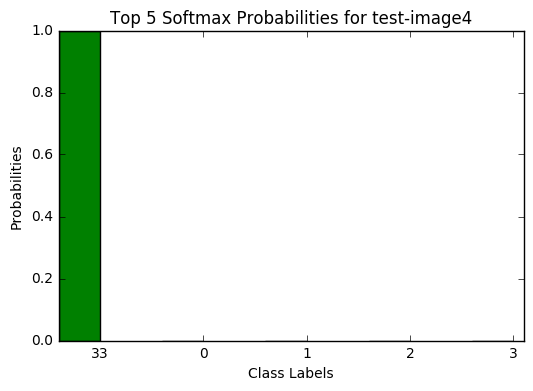

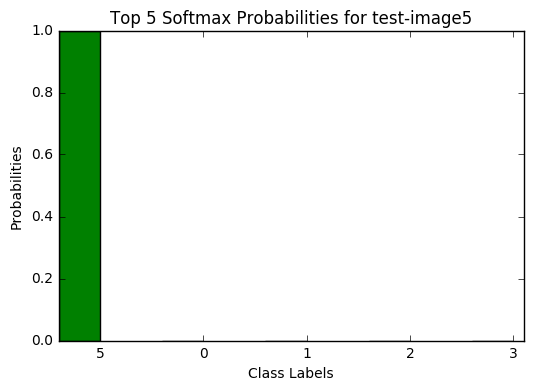

In [14]:
### Visualize the softmax probabilities
N = 5

ind = np.arange(N)  # the x locations for the values

for i in range(5):
    plt.figure(i)
    values = top_k[0][i]
    plt.bar(range(N), values, 0.40, color='g')
    plt.ylabel('Probabilities')
    plt.xlabel('Class Labels')
    plt.title('Top {} Softmax Probabilities for test-image{}'.format(N, str(i+1)))
    plt.xticks(ind+0.40, tuple(top_k[1][i]))

plt.show()

**Answer:**